In [5]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5

In [7]:
!ls

dl.ipynb  fbprophet.ipynb


In [4]:
REGIONS = [['JH', 'Johor', 'JH'], 
           ['PH', 'Pahang', 'PH'],
           ['PRK', 'Perak', 'PRK'], 
           ['OtherPEN', 'Other Pen. States', 'OtherPEN'],
           ['PEN', 'Peninsula', 'Pmalay'],
           ['SBH', 'Sabah', 'SBH'],
           ['SWK', 'Sarawak', 'SWK']]

In [8]:
production = pd.read_csv('../palm_data/production_good.csv')
rainfall = pd.read_csv('../palm_data/rainfall_good.csv')
area = pd.read_csv('../palm_data/area_good.csv')

In [9]:
RAINFALL_LAGS = [6, 7, 8, 9, 10, 11, 12]
PRODUCTION_LAGS = [6, 7, 8, 9, 10, 11, 12]

In [10]:
def process_data(production, rainfall, area, REGIONS, PRODUCTION_LAGS, RAINFALL_LAGS):
    output = {}
    for i, region in enumerate(REGIONS):
        data = production[production.Region == region[0]]
        data = pd.merge(data[['Year', 'Month', 'Production', 'Diff_production']],
                        rainfall[rainfall.Region == region[1]][['Year', 'Month', 'Rainfall']], 
                        on=['Year', 'Month'], how='left')

        data = pd.merge(data, area[area.Region == region[2]][
            ['Year', 'Area_ma', 'Area_npa', 'Area_rpa', 'Area_New', 'Area_ma_new']], on='Year', how='left')
            
        data['Year'] = data['Year'].astype(int)
        data['Month'] = data['Month'].astype(int)
        data.reset_index(inplace=True)

        data.set_index([pd.to_datetime(['{0}-{1}-01'.format(x, y) for (x, y) in zip(data.Year, data.Month)])],
                       inplace=True)

        data.drop(['index', 'Year', 'Area_New', 'Diff_production'], axis=1, inplace=True)
        data['Time'] = np.arange(len(data))

        for lag in RAINFALL_LAGS:
            temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Rainfall.values[:-lag]))
            data['Rainfall_{0}'.format(lag)] = temp

        for lag in PRODUCTION_LAGS:
            temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Production.values[:-lag]))
            data['Production_{0}'.format(lag)] = temp
        
        PRODUCTION = data.Production
        data.drop(['Production'], axis=1, inplace=True)

        data.fillna(data.mean(), inplace=True)

        #  And finally drop rainfalls
        data.drop(['Rainfall'], axis=1, inplace=True)
        ### HERE I CAN ADD FEATURE ENGINEERING!!!

        #  And clip first year
        for col in data.columns:
            data['_'.join([region[1], str(col)])] = data[col]
            data.drop([col], axis=1, inplace=True)
        
        output[region[1]] = (data[max(PRODUCTION_LAGS):], PRODUCTION[max(PRODUCTION_LAGS):])
    return output


In [33]:
DATA = process_data(production, rainfall, area, REGIONS, PRODUCTION_LAGS, RAINFALL_LAGS)
DATA['Peninsula']

(            Peninsula_Month  Peninsula_Area_ma  Peninsula_Area_npa  \
 1999-01-01                1        1856.000000         2052.000000   
 1999-02-01                2        1856.000000         2052.000000   
 1999-03-01                3        1856.000000         2052.000000   
 1999-04-01                4        1856.000000         2052.000000   
 1999-05-01                5        1856.000000         2052.000000   
 ...                     ...                ...                 ...   
 2017-05-01                5        2081.210526         2360.157895   
 2017-06-01                6        2081.210526         2360.157895   
 2017-07-01                7        2081.210526         2360.157895   
 2017-08-01                8        2081.210526         2360.157895   
 2017-09-01                9        2081.210526         2360.157895   
 
             Peninsula_Area_rpa  Peninsula_Area_ma_new  Peninsula_Time  \
 1999-01-01           22.000000            1130.630769              12  

<AxesSubplot:>

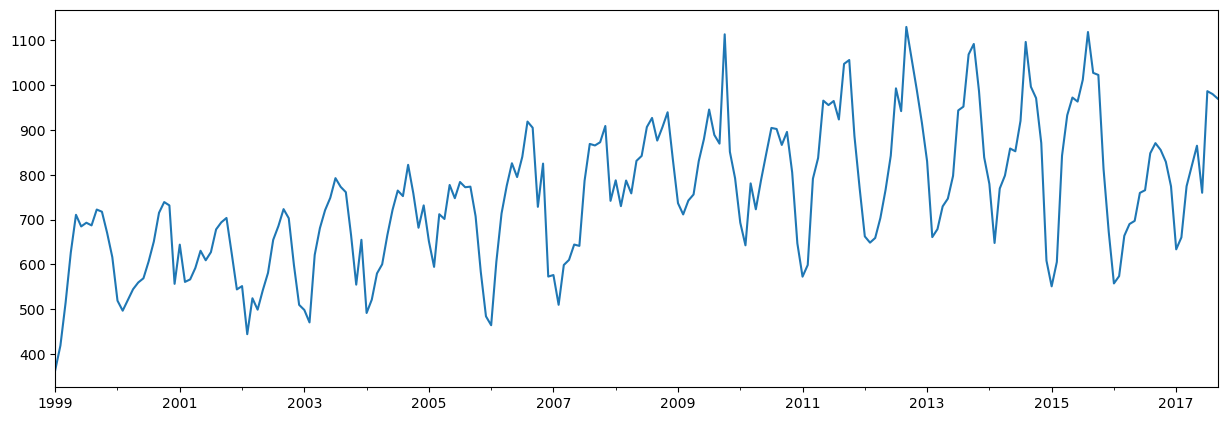

In [12]:
ts = DATA['Peninsula'][1]
ts.plot()

In [42]:
from fbprophet import Prophet

m = Prophet(seasonality_mode='additive',
            growth='logistic',
            yearly_seasonality=True,
            daily_seasonality=True)

m.add_country_holidays(country_name='US')
m.add_seasonality(name='monthly', period=4, fourier_order=5)

val_interval = 6


In [43]:

train_index = ts.index[:-6]
test_index = ts.index[-6:]

train_val = ts.values[:-6]
test_val = ts.values[-6:]

ptrain = pd.DataFrame()
ptrain["ds"] = train_index
ptrain["y"] = train_val

ptrain['floor'] = ptrain['y'].min()
ptrain['cap'] = ptrain['y'].max() + (ptrain['y'].max() *0.2)

# ptrain['floor']=0
# ptrain['cap']=8000

m.fit(ptrain)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
/usr/lib/python3.8/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



/usr/lib/python3.8/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.

/usr/lib/python3.8/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



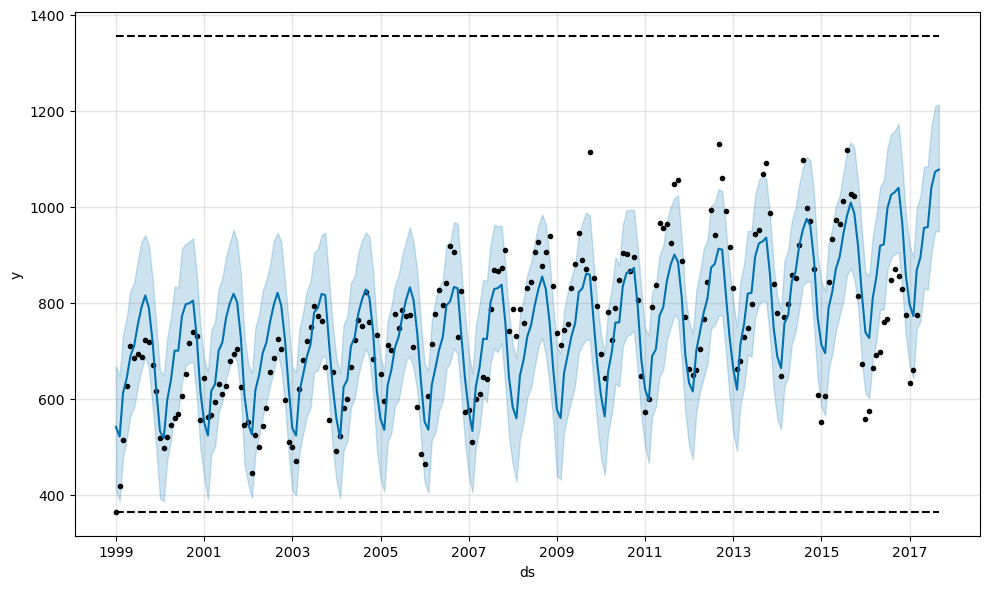

In [44]:
future = m.make_future_dataframe(periods=val_interval, include_history=True, freq="m")
future['floor'] = ptrain['y'].min()
future['cap'] = ptrain['y'].max() + (ptrain['y'].max() *0.2)

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

fig1 = m.plot(forecast)

/usr/lib/python3.8/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.

/usr/lib/python3.8/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.

/usr/lib/python3.8/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



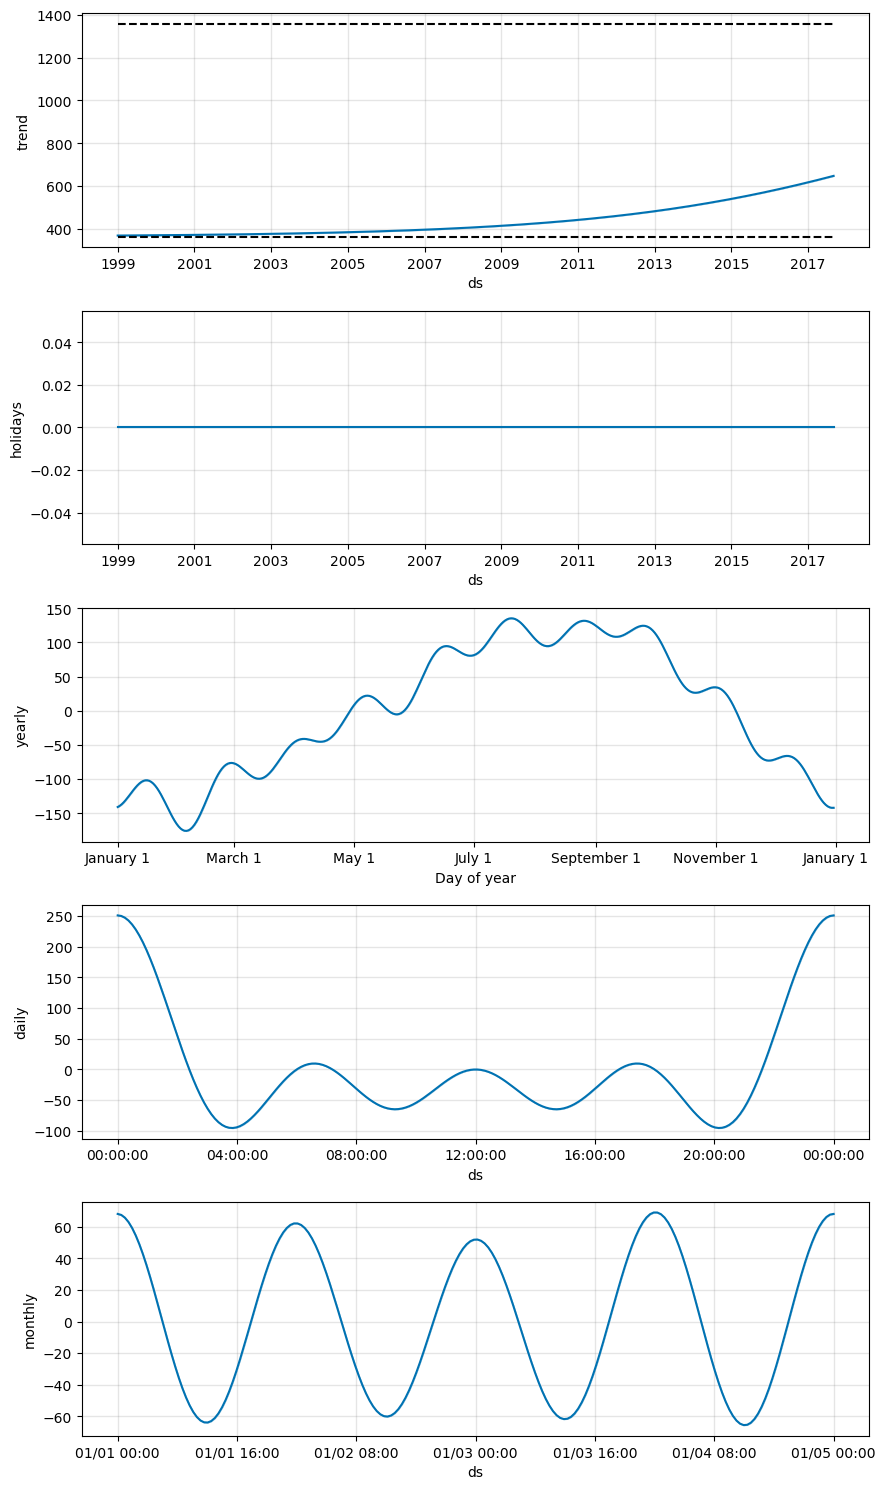

In [20]:
fig = m.plot_components(forecast)

In [16]:
forecast

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1999-01-01,725.969168,1356.2292,364.187,150.682242,343.991868,725.969168,725.969168,0.0,0.0,...,-0.668030,-0.668030,-0.668030,-0.182450,-0.182450,-0.182450,0.0,0.0,0.0,241.000003
1,1999-02-01,730.290752,1356.2292,364.187,123.335693,327.644268,730.290752,730.290752,0.0,0.0,...,-0.690914,-0.690914,-0.690914,-0.213998,-0.213998,-0.213998,0.0,0.0,0.0,225.722492
2,1999-03-01,734.212425,1356.2292,364.187,221.690325,421.131345,734.212425,734.212425,0.0,0.0,...,-0.567242,-0.567242,-0.567242,-0.090326,-0.090326,-0.090326,0.0,0.0,0.0,317.736351
3,1999-04-01,738.573985,1356.2292,364.187,241.067378,439.525502,738.573985,738.573985,0.0,0.0,...,-0.543294,-0.543294,-0.543294,-0.061875,-0.061875,-0.061875,0.0,0.0,0.0,337.311025
4,1999-05-01,742.813998,1356.2292,364.187,282.153853,478.991568,742.813998,742.813998,0.0,0.0,...,-0.482502,-0.482502,-0.482502,0.003078,0.003078,0.003078,0.0,0.0,0.0,384.404439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,2017-04-30,1327.002198,1356.2292,364.187,590.104182,777.239374,1327.002198,1327.002198,0.0,0.0,...,-0.481117,-0.481117,-0.481117,0.000302,0.000302,0.000302,0.0,0.0,0.0,688.558265
221,2017-05-31,1327.529531,1356.2292,364.187,575.850672,769.223585,1327.529531,1327.529531,0.0,0.0,...,-0.490630,-0.490630,-0.490630,0.019162,0.019162,0.019162,0.0,0.0,0.0,676.203292
222,2017-06-30,1328.031057,1356.2292,364.187,731.583216,923.842664,1328.031057,1328.031057,0.0,0.0,...,-0.376375,-0.376375,-0.376375,0.100541,0.100541,0.100541,0.0,0.0,0.0,828.193176
223,2017-07-31,1328.540360,1356.2292,364.187,784.555522,985.933784,1328.540360,1328.540360,0.0,0.0,...,-0.334268,-0.334268,-0.334268,0.147151,0.147151,0.147151,0.0,0.0,0.0,884.451737


In [17]:
forecast[["ds", "yhat"]]

,ds,yhat
0,1999-01-01,241.000003
1,1999-02-01,225.722492
2,1999-03-01,317.736351
3,1999-04-01,337.311025
4,1999-05-01,384.404439
...,...,...
220,2017-04-30,688.558265
221,2017-05-31,676.203292
222,2017-06-30,828.193176
223,2017-07-31,884.451737
